In [1]:
%env CUDA_VISIBLE_DEVICES

'0,1,2'

## Load dataset

In [2]:
from datasets import load_dataset
import os
from tqdm import tqdm
from PIL import Image

dataset = load_dataset("zyxleo/cord_donut_multitask")

/root/miniforge-pypy3/envs/envv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['task', 'image_path', 'ground_truth', 'labels', 'input_ids'],
        num_rows: 800
    })
    test: Dataset({
        features: ['task', 'image_path', 'ground_truth', 'labels', 'input_ids'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['task', 'image_path', 'ground_truth', 'labels', 'input_ids'],
        num_rows: 100
    })
})

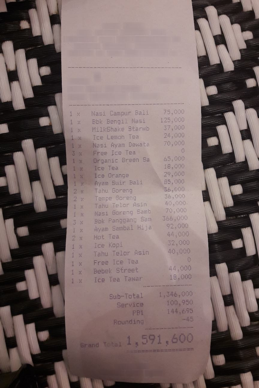

In [4]:
root = os.path.join(os.getcwd(), "lab", "cord")
example = dataset['train'][0]
image = Image.open(os.path.join(root, example['image_path']))
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [5]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"menu": [{"nm": "Nasi Campur Bali", "cnt": "x 1", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "x 1", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "x 1", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "x 1", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "x 1", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "x 3", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "x 1", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "x 1", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "x 1", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "x 1", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "x 2", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "x 2", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "x 1", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "x 1", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "x 3", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "x 1", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "x 2", "price": "44,000"},

In [6]:
from ast import literal_eval

literal_eval(ground_truth)

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': 'x 1', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': 'x 1', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': 'x 1', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': 'x 1', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': 'x 1', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': 'x 3', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': 'x 1', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': 'x 1', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': 'x 1', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': 'x 1', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': 'x 2', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': 'x 2', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': 'x 1', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': 'x 1', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': 'x 3', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': 'x 1', 'price': '92,000'},
  {'nm': 'Hot Tea', '

## Load model and processor

Next, we load the model (Donut is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)), and the processor, which is the object that can be used to prepare inputs for the model.

We'll update some settings for fine-tuning, namely the image size and the max length of the decoder.

In [7]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Next, we instantiate the model with our custom config, as well as the processor. Make sure that all pre-trained weights are correctly loaded (a warning would tell you if that's not the case).

In [8]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
# model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [9]:
from transformers import AutoTokenizer
processor.tokenizer = AutoTokenizer.from_pretrained(os.path.join(root, "cord_tokenizer"))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

In [11]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s>


In [12]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57587


## Create PyTorch dataset

In [13]:
model.decoder.config

MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_final_layer_norm": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 4,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "init_std": 0.02,
  "is_decoder": true,
  "is_encoder_decoder": false,
  "max_length": 768,
  "max_position_embeddings": 1536,
  "model_type": "mbart",
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "scale_embedding": true,
  "transformers_version": "4.35.0",
  "use_cache": true,
  "vocab_size": 57525
}

In [14]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

# added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        # self.gt_token_sequences = []
        # for sample in self.dataset:
        #     ground_truth = json.loads(sample["ground_truth"])
        #     if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
        #         assert isinstance(ground_truth["gt_parses"], list)
        #         gt_jsons = ground_truth["gt_parses"]
        #     else:
        #         assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
        #         gt_jsons = [ground_truth["gt_parse"]]

        #     self.gt_token_sequences.append(
        #         [
        #             self.json2token(
        #                 gt_json,
        #                 update_special_tokens_for_json_key=self.split == "train",
        #                 sort_json_key=self.sort_json_key,
        #             )
        #             + processor.tokenizer.eos_token
        #             for gt_json in gt_jsons  # load json from list of json
        #         ]
        #     )

        # self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        pil_image = Image.open(os.path.join(root, sample["image_path"]))
        # inputs
        pixel_values = processor(pil_image, random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = sample["ground_truth"]
        # target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = torch.tensor(sample["input_ids"])
        labels = torch.tensor(sample["labels"] + [self.ignore_id] * (self.max_length - len(sample["labels"])))
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, input_ids, labels, target_sequence

Next, we instantiate the datasets:

In [15]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
model.decoder.resize_token_embeddings(len(processor.tokenizer))
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("zyxleo/cord_donut_multitask", max_length=max_length,
                             split="train", task_start_token="<s>", prompt_end_token="<s>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("zyxleo/cord_donut_multitask", max_length=max_length,
                             split="validation", task_start_token="<s>", prompt_end_token="<s>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [16]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

Let's verify a batch:

## Define LightningModule

In [17]:
def json2token(obj: Any, sort_json_key: bool = False):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, sort_json_key) for item in obj]
        )
    else:
        obj = str(obj)
        if f"<{obj}/>" in processor.tokenizer.vocab:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj

In [21]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math
import pdb
from donut import JSONParseEvaluator
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only



class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.evaluator = JSONParseEvaluator()

    def training_step(self, batch, batch_idx):
        pixel_values, _, labels, _ = batch
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss

        # pdb.set_trace()

        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, input_ids, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = input_ids

        # pdb.set_trace()
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)

        pdb.set_trace()

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            seq = re.sub(r"(?:(?<=>) | (?=</s_))", "", seq)
            seq = processor.token2json(seq)
            predictions.append(seq)

        accs = []
        f1s = []
        for pred, answer in zip(predictions, answers):
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            # scores.append(self.evaluator.(pred, answer) / max(len(pred), len(answer)))
            answer = json.loads(answer)
            accs.append(self.evaluator.cal_acc(pred, answer))
            f1s.append(self.evaluator.cal_f1([pred], [answer]))
            if self.config.get("verbose", False) and len(accs) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f"       Acc: {accs[-1]:.2f}")
                print(f"        F1: {f1s[-1]:.2f}")
                

        # self.log("val_edit_distance", np.mean(scores))
        self.log("val_acc", np.mean(accs))
        self.log("val_f1", np.mean(f1s))
        
        # return scores
        return accs, f1s

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

In [27]:
config = {"max_epochs":30,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1ae64812b0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1a103c9a90, raw_cell="config = {"max_epochs":30,
          "val_check_in.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.176.50.35/root/Donut/lab/base2cord.ipynb#X36sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1ae64812b0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1a103c9b20, execution_count=27 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1a103c9a90, raw_cell="config = {"max_epochs":30,
          "val_check_in.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.176.50.35/root/Donut/lab/base2cord.ipynb#X36sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _pause_backend() takes 1 positional argument but 2 were given

In [28]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping
import wandb
wandb_logger = WandbLogger(project="Donut", name="base2cord")

class LogGradientsAndBeforeAfterWeightsCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        # log gradients to a json file, where each key correspond to an epoch, and each value is a list of gradients
        if trainer.current_epoch % 5 == 0:
            with open(os.path.join(os.getcwd(), "lab", "logs", "base2cord", "gradients.jsonl"), "a") as f:
                line = {str(trainer.current_epoch): []}
                content = []
                for p in tqdm(pl_module.named_parameters(), desc="Logging gradients"):
                    if p[1].grad is None:
                        item = {p[0]: None}
                    else:
                        item = {p[0]: p[1].grad.tolist()}
                    content.append(item)
                line[str(trainer.current_epoch)] = content
                json.dump(line, f)
                f.write("\n")
    
    def on_fit_start(self, trainer, pl_module):
        # this one logs all weights in the model before fine-tuning
        # clear all logs first
        log_dir = os.path.join(os.getcwd(), "lab", "logs", "base2cord")
        log_filenames = os.listdir(log_dir)
        for log_filename in log_filenames:
            with open(os.path.join(log_dir, log_filename), "w") as f:
                pass
                
        with open(os.path.join(os.getcwd(), "lab", "logs", "base2cord", "before.jsonl"), "w") as f:
            for p in tqdm(pl_module.named_parameters(), desc="Logging weights before fine-tuning"):
                json.dump({p[0]: p[1].tolist()}, f)
                f.write("\n")
        
    
    def on_fit_end(self, trainer, pl_module):
        # this one logs all weights in the model after fine-tuning
        with open(os.path.join(os.getcwd(), "lab", "logs", "base2cord", "after.jsonl"), "w") as f:
            for p in tqdm(pl_module.named_parameters(), desc="Logging weights after fine-tuning"):
                json.dump({p[0]: p[1].tolist()}, f)
                f.write("\n")
                

early_stop_callback = EarlyStopping(monitor="val_f1", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        fast_dev_run=100,
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        # callbacks=[early_stop_callback, LogGradientsAndBeforeAfterWeightsCallback()],
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1ae64812b0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1a104540d0, raw_cell="from pytorch_lightning.loggers import WandbLogger
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.176.50.35/root/Donut/lab/base2cord.ipynb#X40sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _resume_backend() takes 1 positional argument but 2 were given

/root/miniforge-pypy3/envs/envv/lib/python3.9/site-packages/lightning_fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 100 batch(es). Logging and checkpointing is suppressed.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1ae64812b0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1a10454520, execution_count=28 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1a104540d0, raw_cell="from pytorch_lightning.loggers import WandbLogger
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.176.50.35/root/Donut/lab/base2cord.ipynb#X40sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _pause_backend() takes 1 positional argument but 2 were given

In [29]:
# try:
#     with wandb.init():
trainer.fit(model_module)
# except KeyboardInterrupt:
#     wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1ae64812b0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1a26046400, raw_cell="# try:
#     with wandb.init():
trainer.fit(model_.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.176.50.35/root/Donut/lab/base2cord.ipynb#X41sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _resume_backend() takes 1 positional argument but 2 were given

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
807.662   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]> /tmp/ipykernel_85727/2965288300.py(55)validation_step()
     53         pdb.set_trace()
     54 
---> 55         predictions = []
     56         for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
     57             seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")

> /tmp/ipykernel_85727/2965288300.py(56)validation_step()
     54 
     55         predictions = []
---> 56         for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
     57             seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
     58             seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token

> /tmp/ipykernel_85727/2965288300.py(57)validation_step()
     55         predictions = []
     56         for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
---> 57 

TypeError: _pause_backend() takes 1 positional argument but 2 were given